# Image contrast
Reproduces figure 6 and stats in section 3.2.3

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.oneway import anova_oneway
from matplotlib.gridspec import GridSpec

from dataframe_help import calc_contrast, add_relaxometry, add_temperature_w0_sw

sns.set_theme()

In [2]:
contrast_references = {'Adult':
                        {
                            'WM': {'Seg':'T2', 'LabelValue':9, 'True_T2':0.081, 'True_T1':0.254},
                            'GM': {'Seg':'T2', 'LabelValue':8, 'True_T2':0.105 ,'True_T1':0.377}
                        },
                        'Neo':
                        {
                            'WM':{'Seg':'T2', 'LabelValue':4, 'True_T2':0.294, 'True_T1':0.702},
                            'GM': {'Seg':'T2', 'LabelValue':8, 'True_T2':0.139, 'True_T1':0.364}
                        }
                    }
df = pd.read_csv('../data/contrast_df.csv')

df.drop(df[(df['Subject'] == 'P0020') & (df['Session'] == '20240419161029')].index, inplace=True)

df = add_relaxometry(df, '../results')
df = add_temperature_w0_sw(df, '../data')
df_con = calc_contrast(df, contrast_references)
df_con = add_temperature_w0_sw(df_con, '../data')

Adding in temperature, w0 and SW: 100%|██████████| 13496/13496 [00:07<00:00, 1724.67it/s]
/Users/emil/Code/unity_qa_paper/notebooks/dataframe_help.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_contrast = pd.concat((df_contrast, pd.DataFrame.from_dict(D)), ignore_index=True)
Adding in temperature, w0 and SW: 100%|██████████| 241/241 [00:00<00:00, 1697.29it/s]


In [3]:
df_T2 = pd.read_csv('../results/relaxometry_MnCl_mimics.csv')

for age in contrast_references.keys():
    print(age)
    sub_d = contrast_references[age]
    for tissue in sub_d.keys():
        row = df_T2[df_T2['Mimic']==f"{sub_d[tissue]['Seg']} {sub_d[tissue]['LabelValue']}"]
        print(f"{tissue} - T1,T2: {row['T1 [s]'].values[0]:.3f} {row['T2 [s]'].values[0]:.3f} s")

Adult
WM - T1,T2: 0.165 0.095 s
GM - T1,T2: 0.244 0.131 s
Neo
WM - T1,T2: 0.768 0.339 s
GM - T1,T2: 0.244 0.131 s


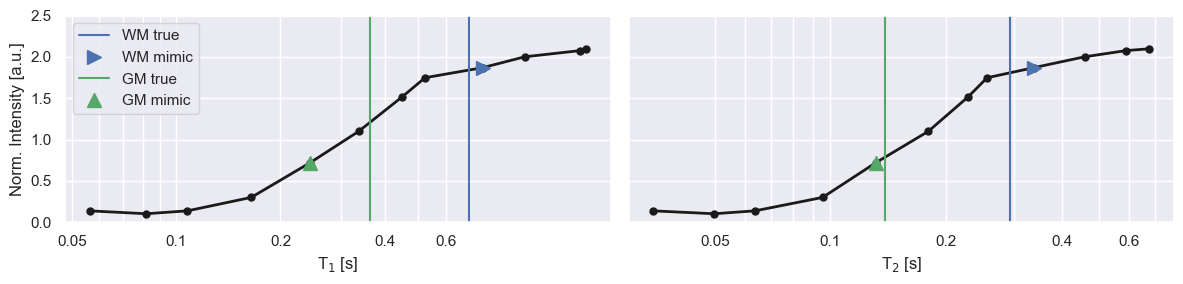

In [4]:
MnCl_thr = 1
data=df[(df['Seg']=='T2') & (df['Run']==1) & (df['Conc'] < MnCl_thr) & (df['Subject']=='P0004') & (df['Session']=='20230629100751')]
data = data.sort_values(by='T2')

fig, axes = plt.subplots(1,2, figsize=(12,3))

for i,k in enumerate(['T1', 'T2']):
    ax = axes[i]
    ax.semilogx(data[k],data['Mean'], 'o-k', linewidth=2, markersize=5)
    ax.grid('both')
    ax.set_xlabel(f'{k} [s]')
    ax.set_ylabel('Norm. Intensity [a.u.]')
    ax.set_xticks([0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], [0.05, '', '', '', '', 0.1, 0.2, '', 0.4, '', 0.6,''])

    ax.plot([contrast_references['Neo']['WM'][f'True_{k}']]*2, [0, 2.5], color='C00', label='WM true')
    mimic_data = data[data['LabelValue']==contrast_references['Neo']['WM']['LabelValue']]
    ax.plot(mimic_data[k], mimic_data['Mean'], '>', color='C00', markersize=10, label='WM mimic')

    ax.plot([contrast_references['Neo']['GM'][f'True_{k}']]*2, [0, 2.5], color='C02', label='GM true')
    mimic_data = data[data['LabelValue']==contrast_references['Neo']['GM']['LabelValue']]
    ax.plot(mimic_data[k], mimic_data['Mean'], '^', color='C02', markersize=10, label='GM mimic')

    ax.set_ylim([0,2.5])

axes[0].set_xlabel(r'T$_1$ [s]')
axes[1].set_xlabel(r'T$_2$ [s]')
axes[1].set_ylabel(None)
axes[1].set_yticklabels([])
axes[0].legend()

plt.tight_layout()
plt.show()

## Figure 6

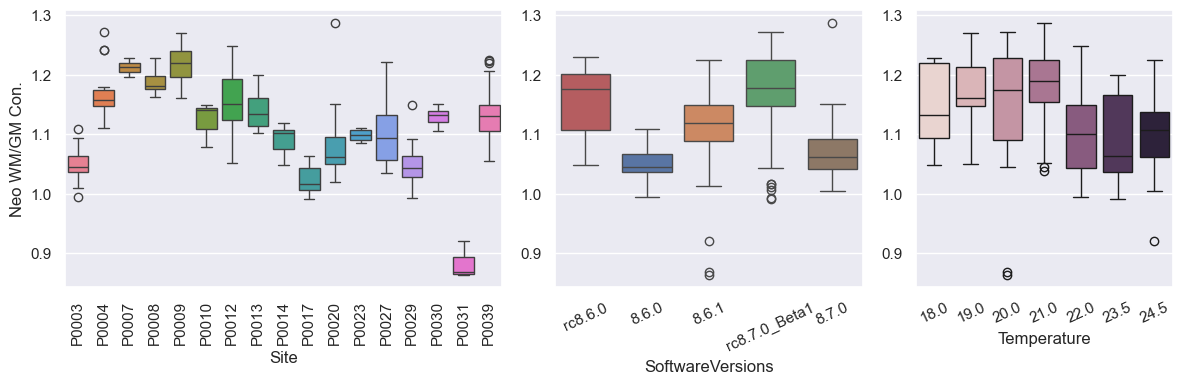

In [5]:
sns.set_theme()

gs = GridSpec(1,3, width_ratios=[17,12,10])
fig = plt.figure(figsize=(12,4))
axes = [fig.add_subplot(gs[i]) for i in range(3)]

sns.boxplot(data=df_con, x='Subject', y='Neonatal WM/GM Contrast', ax=axes[0], hue='Subject', legend=None)

axes[0].set_ylabel('Neo WM/GM Con.')
axes[0].tick_params(axis='x', rotation=90)

sns.boxplot(data=df_con, x='SoftwareVersions', y='Neonatal WM/GM Contrast', ax=axes[1], 
                hue='SoftwareVersions', legend=None, order=['rc8.6.0', '8.6.0', '8.6.1', 'rc8.7.0_Beta1', '8.7.0'])

axes[1].set_ylabel(None)
axes[1].tick_params(axis='x', rotation=25)

sns.boxplot(data=df_con, x='Temperature', 
                y='Neonatal WM/GM Contrast', ax=axes[2], hue='Temperature', legend=None, )

axes[2].set_ylabel(None)
axes[2].tick_params(axis='x', rotation=25)

axes[0].set_xlabel('Site')

plt.tight_layout()
plt.savefig('../results/figure6_contrast_box.png', dpi=300)
plt.show()

In [6]:
my_df = df_con.copy()
my_df.columns = my_df.columns.str.replace(' ', '_')
my_df.columns = my_df.columns.str.replace('/', '')

my_df = my_df[my_df.Temperature < 24.5]

formula = 'Neonatal_WMGM_Contrast ~ Temperature + w0 + C(SoftwareVersions) + C(Subject)'
model = smf.ols(formula, data=my_df).fit()

anova_results = sm.stats.anova_lm(model, typ=2)
print('\n----- Neonatal -----')
print(anova_results)


----- Neonatal -----
                       sum_sq     df          F        PR(>F)
C(SoftwareVersions)  0.045947    5.0   7.657390  2.518119e-06
C(Subject)           0.216591   14.0  12.891597  1.998076e-18
Temperature          0.015428    1.0  12.856243  4.770139e-04
w0                   0.011881    1.0   9.900419  2.055555e-03
Residual             0.153608  128.0        NaN           NaN
